In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import sklearn.gaussian_process as gp
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

In [2]:
def data_load(model_type, option=False, data_opt=False):
    if model_type == "conv":
        data = pd.read_csv("data/conventional.csv").drop("Unnamed: 0", axis=1)
        feat = data.loc[:, "Li":"Contact time, s"]
        target = data.loc[:, "Y(C2), %"]
    elif model_type == "prop":
        data = pd.read_csv("data/proposed.csv").drop("Unnamed: 0", axis=1)
        feat = data.loc[:, "Li":"Contact time, s"]
        target = data.loc[:, "Y(C2), %"]
    elif model_type == "prop2":
        data = pd.read_csv("data/proposed.csv").drop("Unnamed: 0", axis=1)
        feat = data.loc[:, "1_AW":"Contact time, s"]
        target = data.loc[:, "Y(C2), %"]
    elif model_type == "prop3":
        data = pd.read_csv("data/proposed.csv").drop("Unnamed: 0", axis=1)
        for i in range(8):
            data = data.drop([f"{i+1}_ionization enegy", f"{i+1}_AW", f"{i+1}_atomic radius",f"{i+1}_m. p.",f"{i+1}_b. p.", ], axis =1)
        feat = data.loc[:, "1_electronegativity":"Contact time, s"]
        target = data.loc[:, "Y(C2), %"]

    if option:
        idx = (data.loc[:, 'Nr of publication'] <= 421)
        feat = feat[idx]
        target = target[idx]

    if data_opt:
        return feat, target, data
    else:
        return feat, target
    
    
def crossvalid(xx, yy, model, cvf):
    err_trn = []
    err_tes = []
    r_2_tes = []
    r_2_trn = []
    for train_index, test_index in cvf.split(xx):
        x_trn = np.array(xx)[train_index]
        x_tes = np.array(xx)[test_index]
        y_trn = np.array(yy)[train_index]
        y_tes = np.array(yy)[test_index]
        model.fit(x_trn, y_trn)
        x_trn_pred = model.predict(x_trn)
        x_tes_pred = model.predict(x_tes)
        
        err_tes.append(mean_squared_error(x_tes_pred, y_tes))
        err_trn.append(mean_squared_error(x_trn_pred, y_trn))
        r_2_tes.append(r2_score(y_tes, x_tes_pred))
        r_2_trn.append(r2_score(y_trn, x_trn_pred))
    v_tes = np.sqrt(np.array(err_tes))
    v_trn = np.sqrt(np.array(err_trn))
    print("RMSE %1.3f (sd: %1.3f, min:%1.3f, max:%1.3f, det:%1.3f) ... train" % (
        v_trn.mean(), v_trn.std(), v_trn.min(), v_trn.max(), np.array(r_2_trn).mean()))
    print("RMSE %1.3f (sd: %1.3f, min:%1.3f, max:%1.3f, det:%1.3f) ... test" % (
        v_tes.mean(), v_tes.std(), v_tes.min(), v_tes.max(), np.array(r_2_tes).mean()))
    ret = {}
    ret['trn_mean'] = v_trn.mean()
    ret['trn_std'] = v_trn.std()
    ret['trn_r2'] = np.array(r_2_trn).mean()
    ret['tes_mean'] = v_tes.mean()
    ret['tes_std'] = v_tes.std()
    ret['tes_r2'] = np.array(r_2_tes).mean()
    return ret


In [ ]:
MODEL_TYPES = ['conv', 'prop', 'prop3']
errors = {}
cvf = KFold(n_splits = 10, random_state = 1126, shuffle = True)
log_param1 = [1e-2, 1e-1, 1.0, 10, 1e2]
log_param2 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
log_param3 = [1.0, 10, 1e2, 1e3, 1e4, 1e5]

for model_type in MODEL_TYPES:
    
    feat, target = data_load(model_type)
    
    #Lasso
    cvmodel = GridSearchCV(Lasso(),
                           param_grid = {'alpha': log_param1},
                           n_jobs = -1)
    errors['Lasso_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target),
                                                       cvmodel, cvf)

    #Ridge
    cvmodel = GridSearchCV(Ridge(),
                           param_grid = {'alpha': log_param1},
                           n_jobs = -1)
    errors['Ridge_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target),
                                                       cvmodel, cvf)

    #GPR
    kernel = gp.kernels.Matern(nu = 2.5)
    cvmodel = GridSearchCV(gp.GaussianProcessRegressor(kernel = kernel,
                                                       normalize_y = True,
                                                       n_restarts_optimizer = 10,
                                                       random_state = 1126),
                           param_grid = {'alpha':log_param2},
                           n_jobs = -1)
    errors['GPR_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target),
                                                     cvmodel, cvf)

    #SVR
    cvmodel = GridSearchCV(SVR(kernel = 'rbf'),
                           param_grid = {'C': log_param3,
                                         'gamma':log_param2,
                                         'epsilon':log_param1},
                           n_jobs = -1)
    errors['SVR_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target), 
                                                     cvmodel, cvf)

    #RFRm
    cvmodel = GridSearchCV(RandomForestRegressor(n_jobs = -1, random_state = 1126),
                           param_grid = {'n_estimators':[500, 1000]},
                           n_jobs = -1)
    errors['RFR_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target),
                                                                        cvmodel, cvf)

    #ETR
    cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1126),
                           param_grid = {'n_estimators':[500, 1000]},
                           n_jobs = -1)
    errors['ETR_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target),
                                                     cvmodel, cvf)

    #XGB
    cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1126),
                           param_grid = {'n_estimators':[500, 1000]},
                           n_jobs = -1)
    errors['XGB_{}'.format(model_type)] = crossvalid(np.array(feat), np.array(target),
                                                     cvmodel, cvf)
                                                     


/Users/takaomotoshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21844.609565181025, tolerance: 18.535591563361418
  positive)


RMSE 5.822 (sd: 0.103, min:5.545, max:5.985, det:0.281) ... train
RMSE 5.888 (sd: 0.162, min:5.659, max:6.192, det:0.261) ... test
RMSE 5.692 (sd: 0.019, min:5.654, max:5.716, det:0.313) ... train
RMSE 5.796 (sd: 0.157, min:5.579, max:6.104, det:0.284) ... test


/Users/takaomotoshi/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
methods = ['Lasso', 'Ridge','GPR', 'SVR', 'RFR', 'ETR', 'XGB']

In [ ]:
conv = ['{}_conv'.format(m) for m in methods ]
prop1 = ['{}_prop'.format(m) for m in methods ]
prop3 = ['{}_prop3'.format(m) for m in methods ]

conv_mean = [5.888, 5.796, 5.164, 5.294, 3.664, 3.643, 3.643]
prop1_mean = [5.884, 5.534, 5.507, 5.044, 3.664, 3.516, 3.516]
prop3_mean = [errors[m]['tes_mean'] for m in prop3]


In [ ]:
width =0.25
ind = np.arange(len(methods))
plt.bar(ind,conv_mean, width, color = 'blue', label = 'conventional')
plt.bar(ind+width, prop1_mean, width, color = 'red', label = 'Proposed(Exploitative)')
plt.bar(ind+2*width, prop3_mean, width, color = 'orange', label = 'Proposed(Explorative)')

for x,y in zip(ind, conv_mean):
    plt.text(x, y+0.2, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)

for x,y in zip(ind, prop1_mean):
    plt.text(x+ width, y+0.2, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)  

for x,y in zip(ind, prop3_mean):
    plt.text(x+2*width, y+0.2, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)  
    
plt.xticks(ind + width, methods)
plt.ylabel('Test RMSE [%]')

In [4]:
feat, target = data_load('conv')
elem_nums = (feat.loc[:, 'Li':'Bi'] > 0).sum()

In [5]:
elem_nums = elem_nums.sort_values()

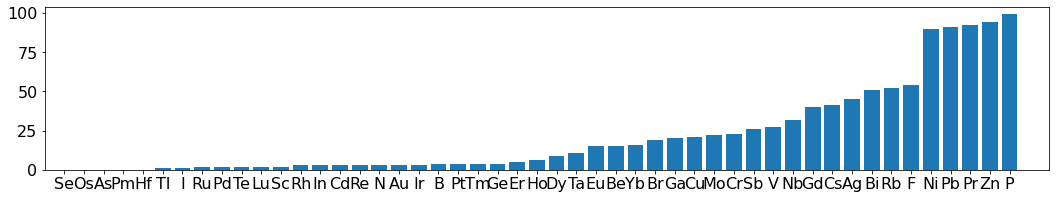

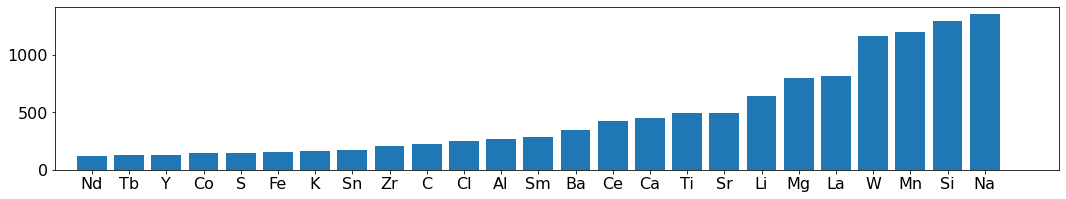

In [14]:
plt.rcParams["font.size"] = 16
plt.figure(figsize = (18, 3))
idx = elem_nums <= 100
x = np.arange(len(elem_nums[idx]))
plt.bar(x, elem_nums[idx])
plt.xticks(x, elem_nums[idx].index, fontsize =16)
plt.xlim([-1, len(elem_nums[idx]) + 1])
plt.savefig('out/num_elem_under_100.png')

plt.figure(figsize = (18, 3))
idx = elem_nums >= 100
x = np.arange(len(elem_nums[idx]))
plt.bar(x, elem_nums[idx])
plt.xticks(x, elem_nums[idx].index, fontsize = 16)
plt.xlim([-1, len(elem_nums[idx]) + 1])
plt.savefig('out/num_elem_over_100.png')

In [21]:
elem_nums[idx].shape

(49,)

In [24]:
np.arange(len(elem_nums[idx])).shape

(49,)